In [1]:
%matplotlib inline

# A simple TPCPLM workflow

#### By Chitrak Banerjee

In this example, we show how to perform a simple differential expression analysis using TPCPLM 
- First step we implement pydeseq2 module and extract the p-values
- Second step we implement wilcoxon p-values and apply Benjamini-Hochberg p-value adjust
- Third step we combine both p-values by taking minimum or using Cauchy combination test using the implementation from https://gist.github.com/ryananeff/c66cdf086979b13e855f2c3d0f3e54e1

We start by importing required packages and setting up an optional path to save results.


In [29]:
import os
import pickle as pkl
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
import ptitprince as pt
import seaborn as sns

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data
from upsetplot import plot



SAVE = False  # whether to save the outputs of this notebook

if SAVE:
    # Replace this with the path to directory where you would like results to be saved
    OUTPUT_PATH = "./synthetic_example"
    os.makedirs(OUTPUT_PATH, exist_ok=True)  # Create path if it doesn't exist

## Preprocess Step
- For this tutorial we are using the Brain RNA seq data obtained from $\color{red}{\text{SC2P}}$ R-package
- The count data and metadata is preprocessed and converted from .rda format to .csv format using tpcplm_preprocessing.ipynb

In [3]:
count_df = pd.read_csv('count_df.csv', index_col=0)

In [4]:
genes_to_keep = count_df.columns[count_df.sum(axis=0) >= 10]
count_df = count_df[genes_to_keep]

In [5]:
count_df.columns

Index(['A2M ', 'A2ML1 ', 'A2MP1 ', 'AAAS ', 'AACS ', 'AADAT ', 'AAGAB ',
       'AAK1 ', 'AAMP ', 'AARS ',
       ...
       'ZXDA ', 'ZXDB ', 'ZXDC ', 'ZYG11B ', 'ZYX ', 'ZZEF1 ', 'ZZZ3 ',
       'no_feature ', 'ambiguous ', 'alignment_not_unique '],
      dtype='object', length=10304)

In [6]:
metadata = pd.read_csv('metadata.csv', index_col=0)

## Single factor analysis

- In this first step, we use the ``celltype`` column as our design factor. That is, we compare gene expressions of samples that have ``astrocytes`` to those that have ``oligodendrocytes``.

.. currentmodule:: pydeseq2.dds

### Read counts modeling with the :class:`DeseqDataSet` class

We start by creating a :class:`DeseqDataSet`
object from the count and metadata data.
A :class:`DeseqDataSet` fits dispersion and
log-fold change (LFC) parameters from the data, and stores them.


In [7]:
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts=count_df,
    metadata=metadata,
    design_factors="celltype",
    refit_cooks=True,
    inference=inference,
    # n_cpus=8, # n_cpus can be specified here or in the inference object
)

A :class:`DeseqDataSet` has two mandatory
arguments: a ``count_df`` and a ``metadata`` dataframe, like the ones we've loaded in the
first part of this tutorial.

Next, we should specify the ``design_factor``, i.e. the column of the ``metadata``
dataframe that will be used to compare samples.

<div class="alert alert-info"><h4>Note</h4><p>The ``"condition"`` argument passed to ``design_factors`` corresponds to a column
  from the ``metadata`` dataframe we loaded earlier.
  You might need to change it according to your own dataset.</p></div>

Several other arguments may be optionally specified (see the :doc:`API documentation
</api/docstrings/pydeseq2.dds.DeseqDataSet>`).
Among those, the ``refit_cooks`` argument (set to ``True`` by default), controls
whether Cooks outlier should be refitted (which is advised, in general) and ``n_cpus``
sets the number of CPUs to use for computation. Here, we use 8 threads. Feel free to
adapt this to your setup or to set to ``None`` to use all available CPUs.

<div class="alert alert-info"><h4>Note</h4><p>In the case of the provided synthetic data, there won't be any Cooks outliers.</p></div>

Once a :class:`DeseqDataSet` was initialized,
we may run the :meth:`deseq2() <DeseqDataSet.deseq2>` method
to fit dispersions and LFCs.

In [8]:
dds.deseq2()


if SAVE:
    with open(os.path.join(OUTPUT_PATH, "dds.pkl"), "wb") as f:
        pkl.dump(dds, f)

Fitting size factors...
... done in 0.05 seconds.

Fitting dispersions...
... done in 11.95 seconds.

Fitting dispersion trend curve...
... done in 0.53 seconds.

Fitting MAP dispersions...
... done in 12.64 seconds.

Fitting LFCs...
... done in 29.84 seconds.

Calculating cook's distance...
... done in 0.25 seconds.

Replacing 6160 outlier genes.

Fitting dispersions...
... done in 7.15 seconds.

Fitting MAP dispersions...
... done in 6.95 seconds.

Fitting LFCs...
... done in 12.36 seconds.



In [9]:
print(dds)

AnnData object with n_obs × n_vars = 100 × 10304
    obs: 'celltype'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted'
    layers: 'normed_counts', '_mu_hat', 'cooks', 'replace_cooks'


Hence, parameters are stored according to the :class:`AnnData <anndata.AnnData>` data
structure, with key-based data fields. In particular,

- ``X`` stores the count data,
- ``obs`` stores design factors,
- ``obsm`` stores sample-level data, such as ``"design_matrix"`` and
  ``"size_factors"``,
- ``varm`` stores gene-level data, such as ``"dispersions"`` and ``"LFC"``.


As an example, here is how we would access dispersions and LFCs
(in natural log scale):


In [10]:
print(dds.varm["dispersions"])

[ 22.06582599  13.73257549 100.         ...   0.2937033    0.12006193
   0.38642842]


In [11]:
print(dds.varm["LFC"])

                       intercept  celltype_oligodendrocytes_vs_astrocytes
A2M                     1.136606                                -0.501976
A2ML1                   3.856395                                -5.682209
A2MP1                   0.000000                                 0.000000
AAAS                    3.237721                                -0.761293
AACS                    0.474422                                -0.233716
...                          ...                                      ...
ZZEF1                   3.346352                                -1.066857
ZZZ3                    3.101379                                 1.045969
no_feature             14.258378                                -0.691910
ambiguous               8.814790                                 0.076509
alignment_not_unique   13.265492                                -0.000838

[10304 rows x 2 columns]


.. currentmodule:: pydeseq2.ds

### Statistical analysis with the :class:`DeseqStats` class

Now that dispersions and LFCs were fitted, we may proceed with statistical tests to
compute p-values and adjusted p-values for differential expresion. This is the role of
the :class:`DeseqStats` class. It has a unique mandatory argument, ``dds``, which
should be a *fitted* :class:`DeseqDataSet <pydeseq2.dds.DeseqDataSet>`
object.


In [12]:
stat_res = DeseqStats(dds, inference=inference)

It also has a set of optional keyword arguments (see the :doc:`API documentation
</api/docstrings/pydeseq2.ds.DeseqStats>`), among which:

- ``alpha``: the p-value and adjusted p-value significance threshold (``0.05``
  by default),
- ``cooks_filter``: whether to filter p-values based on cooks outliers
  (``True`` by default),
- ``independent_filter``: whether to perform independent filtering to correct
  p-value trends (``True`` by default).


In [13]:
stat_res.summary()

if SAVE:
    with open(os.path.join(OUTPUT_PATH, "stat_results.pkl"), "wb") as f:
        pkl.dump(stat_res, f)

Running Wald tests...


Log2 fold change & Wald test p-value: celltype oligodendrocytes vs astrocytes
                           baseMean  log2FoldChange     lfcSE      stat  \
A2M                    2.604841e+00       -0.724198  1.411678 -0.513005   
A2ML1                  3.100510e+01       -8.197695  1.228851 -6.671027   
A2MP1                  0.000000e+00        0.000000  0.000000  0.000000   
AAAS                   2.030063e+01       -1.098313  1.142333 -0.961465   
AACS                   1.537254e+00       -0.337181  2.322242 -0.145197   
...                             ...             ...       ...       ...   
ZZEF1                  2.129465e+01       -1.539150  0.804971 -1.912056   
ZZZ3                   3.778749e+01        1.509014  1.002464  1.505305   
no_feature             1.261673e+06       -0.998215  0.161080 -6.197009   
ambiguous              6.938320e+03        0.110379  0.103059  1.071026   
alignment_not_unique   5.767583e+05       -0.001209  0.184766 -0.006541   

                     

... done in 1.78 seconds.



### Check for some pvalue obtained from Deseq2
- As we see a few pvalues are ``NaN`` we would replace them with 1
- We would also apply Benjamini-Hochberg pvalue correction once the ``NaN`` values are imputed

In [14]:
stat_res.results_df[stat_res.results_df.pvalue.isna()]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A2MP1,0.0,0.0,0.0,0.0,NaN,NaN
ARHGDIB,0.0,0.0,0.0,0.0,NaN,NaN
BIRC5,0.0,0.0,0.0,0.0,NaN,NaN
CASP1,0.0,0.0,0.0,0.0,NaN,NaN
CHRNA2,0.0,0.0,0.0,0.0,NaN,NaN
FBLN5,0.0,0.0,0.0,0.0,NaN,NaN
GPRIN3,0.0,0.0,0.0,0.0,NaN,NaN
GPX3,0.0,0.0,0.0,0.0,NaN,NaN
HTR5A,0.0,0.0,0.0,0.0,NaN,NaN
IL6,0.0,0.0,0.0,0.0,NaN,NaN


In [15]:
deseq2_res = stat_res.results_df.copy()
deseq2_res['pvalue'] = deseq2_res['pvalue'].fillna(1)

### Function for Benjamini-Hochberg correction

In [16]:
def p_adjust_bh(p):
    """Benjamini-Hochberg p-value correction for multiple hypothesis testing."""
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig]

In [17]:
deseq2_res['padj'] = p_adjust_bh(deseq2_res['pvalue'])

## Next we implement the wilcoxon ranksum comparison by the celltypes across all genes
#### Wilcoxon test for two sample comparison
- Here we first merge the count_df and metadata into a single frame
- We split the samples by ``celltype``
- use Wilcoxon ranksums test to compare

In [18]:
combined = count_df.merge(metadata, on=count_df.index)

In [19]:
group1 = combined[combined['celltype'] == 'astrocytes']
group2 = combined[combined['celltype'] == 'oligodendrocytes']

In [20]:
wilcoxon = [scipy.stats.ranksums(group1[col], group2[col])[1] for col in count_df.columns]

In [21]:
q_wilcoxon = p_adjust_bh(wilcoxon)

In [22]:
p_val_df_wilcoxon = pd.DataFrame({'genes': list(stat_res.results_df.index),'pvalue_wc': wilcoxon, 'padj_wc': q_wilcoxon})

### Combining both methods
- after we individually run deseq2 and wilcoxon we merge the results together
- then we combine the pvalues from each genes by taking min of the pvalues and using cauchy combination test (CCT)
- once pvalues are combined by each method we apply BH correction on both the methods

<div class="alert alert-info"><h4>Check</h4><p>To ensure there are no NULL pvalues</p></div>

In [26]:
(deseq2_res.merge(p_val_df_wilcoxon, left_on = deseq2_res.index, right_on = "genes")
                [['pvalue', 'padj', 'pvalue_wc', 'padj_wc']].isna().any())

pvalue       False
padj         False
pvalue_wc    False
padj_wc      False
dtype: bool

In [27]:
frame = deseq2_res.merge(p_val_df_wilcoxon, left_on = deseq2_res.index, right_on = "genes")

### Function for Cauchy combination test
- Cauchy combination test using the implementation from https://gist.github.com/ryananeff/c66cdf086979b13e855f2c3d0f3e54e1

In [31]:
def acat_test(pvalues,weights=None):
    '''acat_test()
    Aggregated Cauchy Assocaition Test
    A p-value combination method using the Cauchy distribution.
    
    Inspired by: https://github.com/yaowuliu/ACAT/blob/master/R/ACAT.R
    
    Author: Ryan Neff
    
    Inputs:
        pvalues: <list or numpy array>
            The p-values you want to combine.
        weights: <list or numpy array>, default=None
            The weights for each of the p-values. If None, equal weights are used.
    
    Returns:
        pval: <float>
            The ACAT combined p-value.
    '''
    if any(np.isnan(pvalues)):
        raise Exception("Cannot have NAs in the p-values.")
    if any([(i>1)|(i<0) for i in pvalues]):
        raise Exception("P-values must be between 0 and 1.")
    if any([i==1 for i in pvalues])&any([i==0 for i in pvalues]):
        raise Exception("Cannot have both 0 and 1 p-values.")
    if any([i==0 for i in pvalues]):
#         print("Warn: p-values are exactly 0.")
        return 0
    if any([i==1 for i in pvalues]):
#         print("Warn: p-values are exactly 1.")
        return 1
    if weights==None:
        weights = [1/len(pvalues) for i in pvalues]
    elif len(weights)!=len(pvalues):
        raise Exception("Length of weights and p-values differs.")
    elif any([i<0 for i in weights]):
        raise Exception("All weights must be positive.")
    else:
        weights = [i/len(weights) for i in weights]
    
    pvalues = np.array(pvalues)
    weights = np.array(weights)
    
    if any([i<1e-16 for i in pvalues])==False:
        cct_stat = sum(weights*np.tan((0.5-pvalues)*np.pi))
    else:
        is_small = [i<(1e-16) for i in pvalues]
        is_large = [i>=(1e-16) for i in pvalues]
        cct_stat = sum((weights[is_small]/pvalues[is_small])/np.pi)
        cct_stat += sum(weights[is_large]*np.tan((0.5-pvalues[is_large])*np.pi))
    
    if cct_stat>1e15:
        pval = (1/cct_stat)/np.pi
    else:
        pval = 1 - scipy.stats.cauchy.cdf(cct_stat)
    
    return pval

In [32]:
frame['pvalue_cct'] = frame.apply(lambda x: acat_test([x['pvalue'], x['pvalue_wc']]),axis = 1)


In [33]:
frame['pvalue_min'] = frame.apply(lambda x: min(x['pvalue'], x['pvalue_wc']),axis = 1)

### BH corrected min pvalue

In [34]:
frame['pvalue_min_adj'] = p_adjust_bh(frame['pvalue_min'])

### BH corrected CCT pvalue

In [35]:
frame['pvalue_cct_adj'] = p_adjust_bh(frame['pvalue_cct'])

In [41]:
print(f"{len(frame[frame['pvalue_cct_adj'] < 0.05])}", "of the genes are significant after using CCT and BH correction")
print(f"{len(frame[frame['pvalue_min_adj'] < 0.05])}", "of the genes are significant after taking the minimum of pvalues from Deseq2 and Wilcoxon and BH correction")
print(f"{len(frame[frame['padj_wc'] < 0.05])}", "of the genes are significant after using Wilcoxon and BH correction")
print(f"{len(frame[frame['padj'] < 0.05])}", "of the genes are significant after using Deseq2 and BH correction")


2593 of the genes are significant after using CCT and BH correction
2923 of the genes are significant after taking the minimum of pvalues from Deseq2 and Wilcoxon and BH correction
1872 of the genes are significant after using Wilcoxon and BH correction
2342 of the genes are significant after using Deseq2 and BH correction


<div class="alert alert-info"><h4>Check</h4><p>As it can be seen that more genes are identified as signifcantly different across the celltypes when we considered combining the Deseq2 and Wilcoxon together to obtain the respective pvalues</p></div>

### Upset plot of singinficant genes by taking the union of the overlapped signofocant genes

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

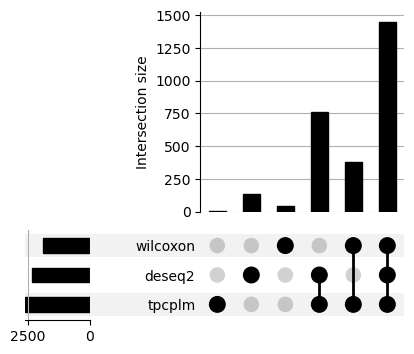

In [45]:
set1 = set(frame[frame.padj< 0.05].genes)
set2 = set(frame[frame.padj_wc < 0.05].genes)
set3 = set(frame[frame.pvalue_cct_adj < 0.05].genes)

set_names = ['deseq2', 'wilcoxon', 'tpcplm']
all_elems = set1.union(set2).union(set3)
df = pd.DataFrame([[e in set1, e in set2, e in set3] for e in all_elems], columns = set_names)
df_up = df.groupby(set_names).size()
plot(df_up, orientation='horizontal')


In [46]:
df_up

deseq2  wilcoxon  tpcplm
False   False     True         2
        True      False       43
                  True       380
True    False     False      131
                  True       762
        True      True      1449
dtype: int64

### Below we obtain some genes to further verify where:
- Each method fail to find significant mean difference across each of the method but the combined min or cauchy combined BH corrected p values are significant

In [47]:
g = frame[(frame.padj> 0.05) & (frame.padj_wc > 0.05) & (frame.pvalue_min_adj < 0.05)].sort_values(by = 'pvalue_min_adj')[:10].genes

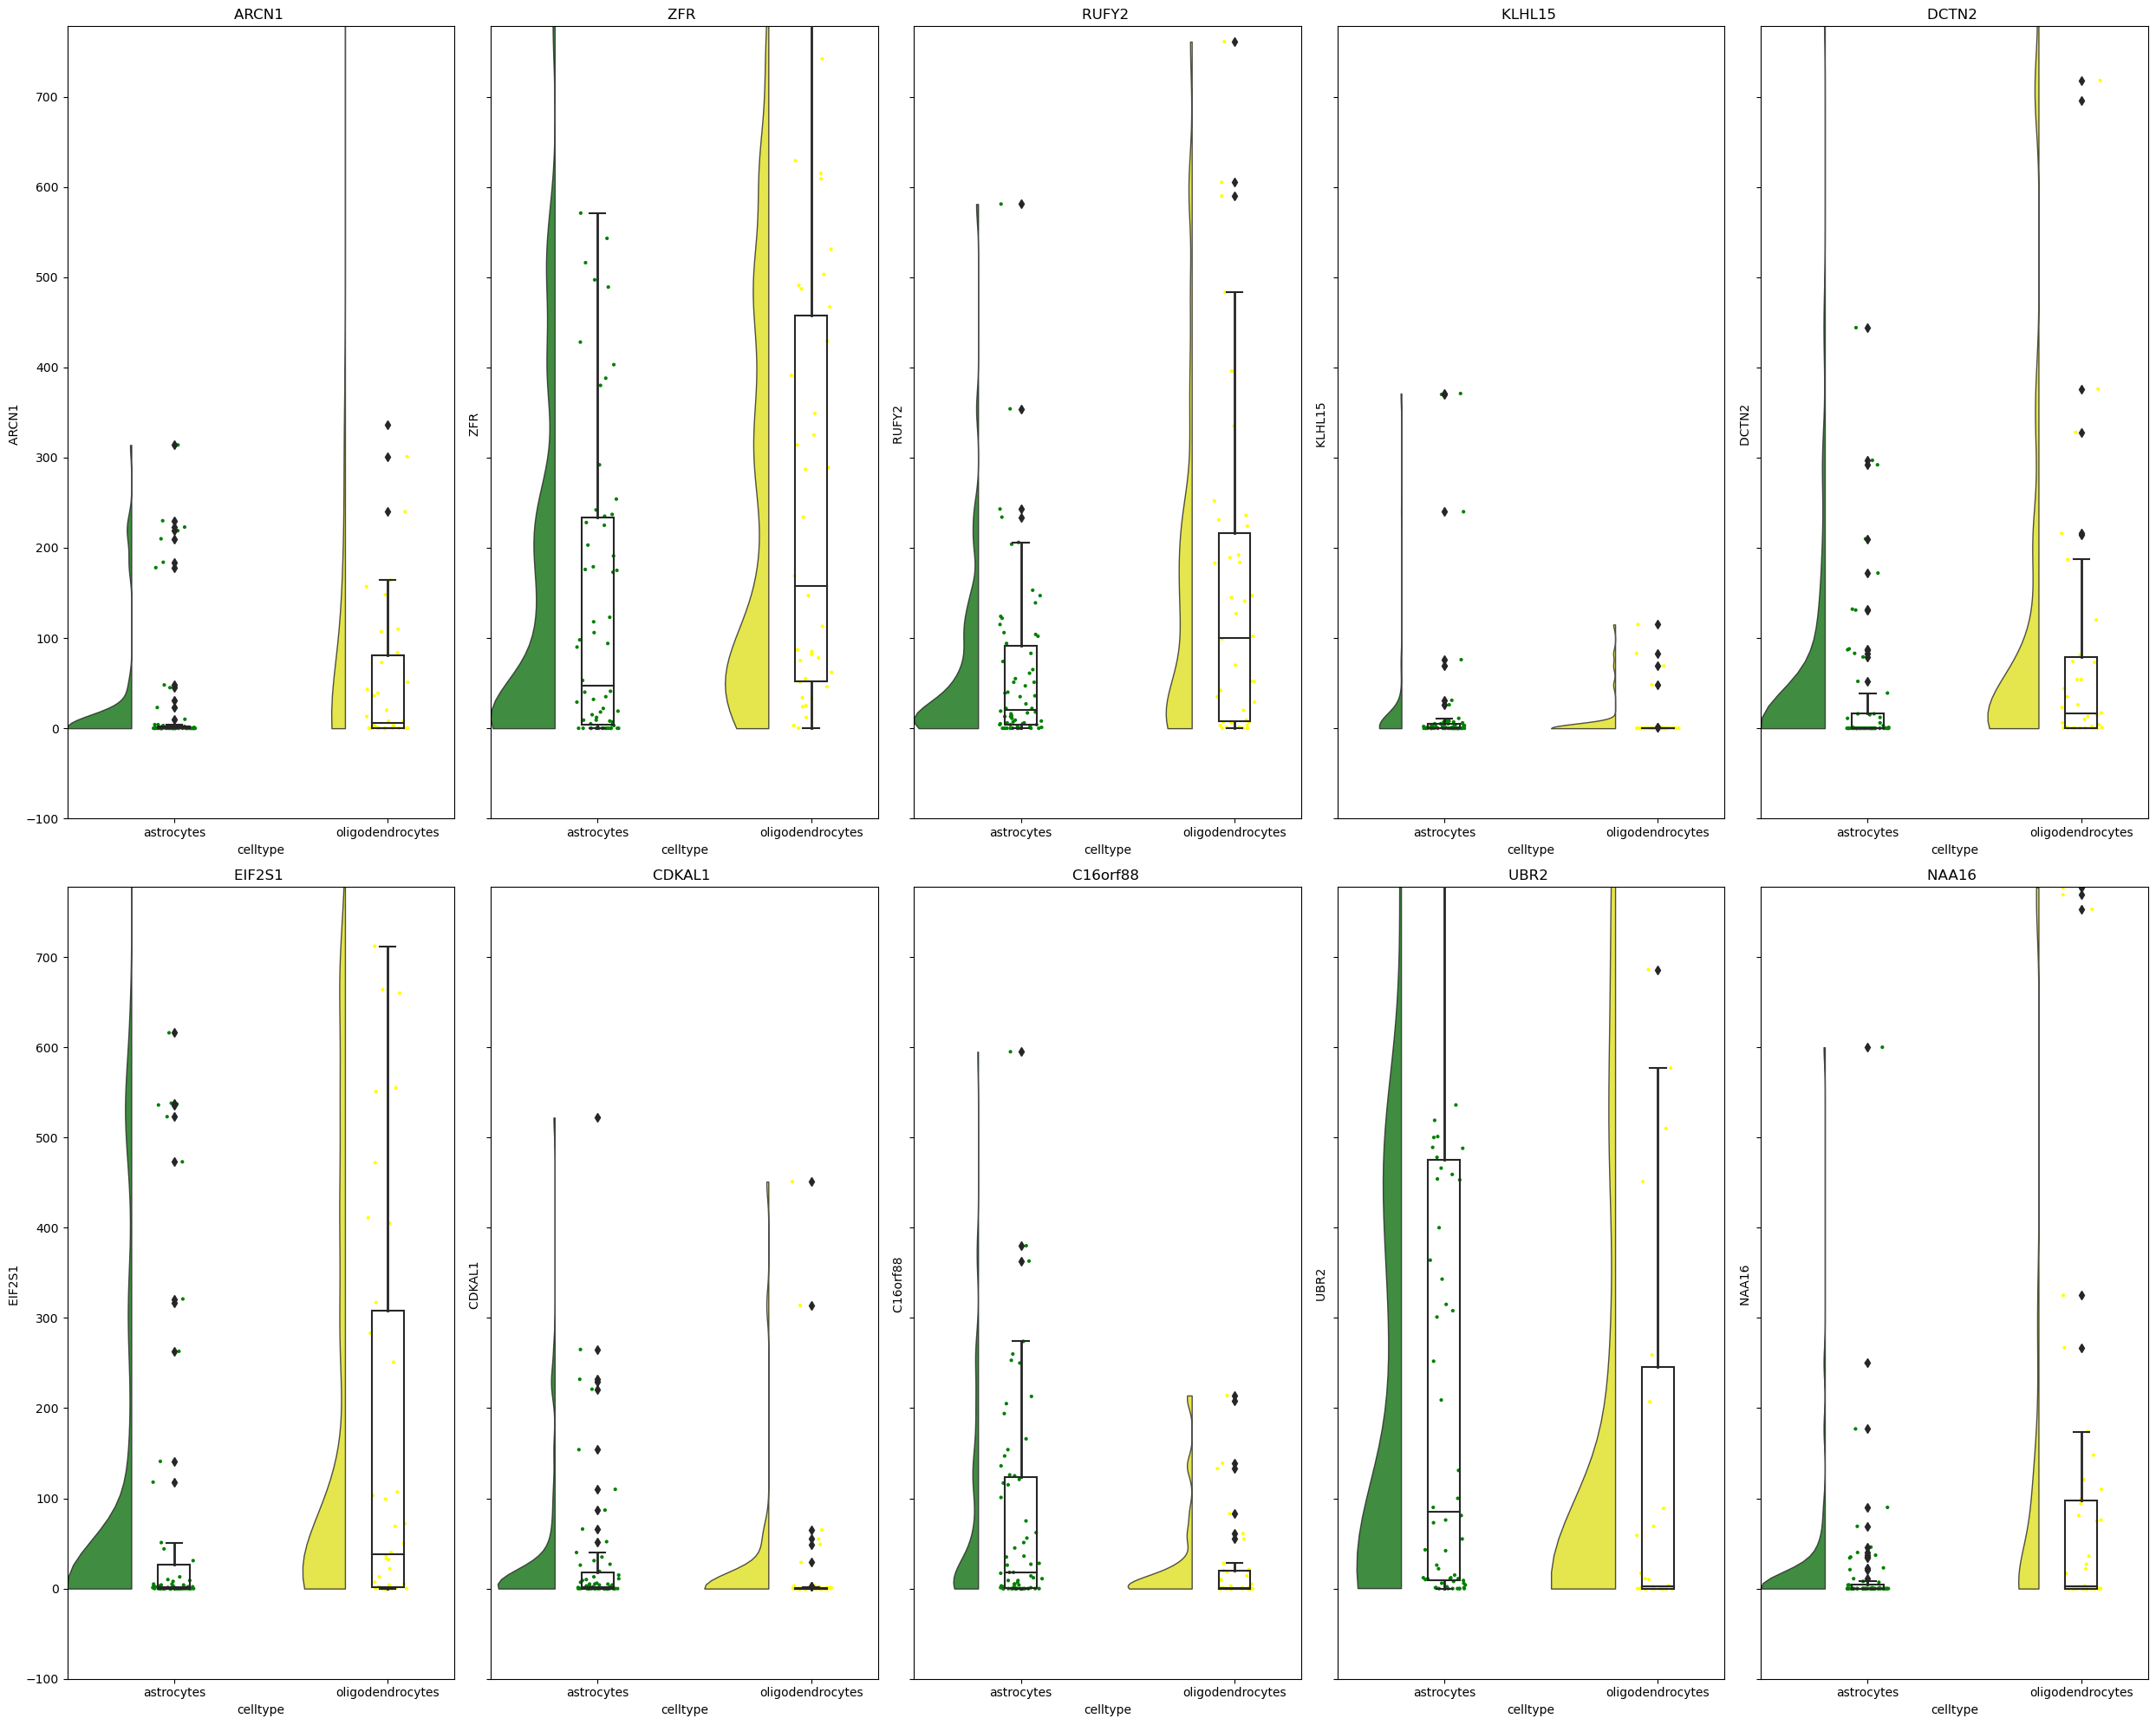

In [48]:
features = list(g)

palette = {'astrocytes': 'green', 'oligodendrocytes': 'yellow'}
# Plot multiple raincloud plots for the 10 features in a single row
fig, axes = plt.subplots(2, 5, figsize=(25, 20), sharey=True)
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    
    # Create the Raincloud Plot using ptitprince
    pt.RainCloud(x='celltype', y=feature, data=combined,
                 palette=palette, width_viol=0.6, alpha=0.8, ax=ax, orient='v')
    
    # Set title for each subplot
    ax.set_title(feature)
    
    ax.set_ylim(-100, combined[feature].max() + 1)

# Adjust layout and remove redundant frames
plt.tight_layout()
plt.show()


In [53]:
stat_res.results_df[stat_res.results_df.index.isin(g)]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ARCN1,38.666447,1.651725,0.909786,1.815509,0.069446,0.177289
C16orf88,52.991780,-1.456158,0.643280,-2.263648,0.023596,0.076609
CDKAL1,20.605382,-1.808086,0.809905,-2.232467,0.025584,0.081541
DCTN2,62.086492,1.031259,0.864491,1.192909,0.232905,0.418016
EIF2S1,91.058404,0.800663,0.726807,1.101617,0.270628,0.461679
KLHL15,3.824222,-2.196290,1.048681,-2.094335,0.036230,0.107173
NAA16,38.024709,1.558194,1.001547,1.555788,0.119759,0.262852
RUFY2,82.851085,1.044480,0.475812,2.195152,0.028153,0.087762
UBR2,265.672181,-0.945861,0.641903,-1.473526,0.140609,0.295045
ZFR,157.289839,0.422770,0.483372,0.874625,0.381778,0.574560


In [49]:
g1 = frame[(frame.padj> 0.05) & (frame.padj_wc > 0.05) & (frame.pvalue_cct_adj < 0.05)].sort_values(by = 'pvalue_cct_adj')[:10].genes


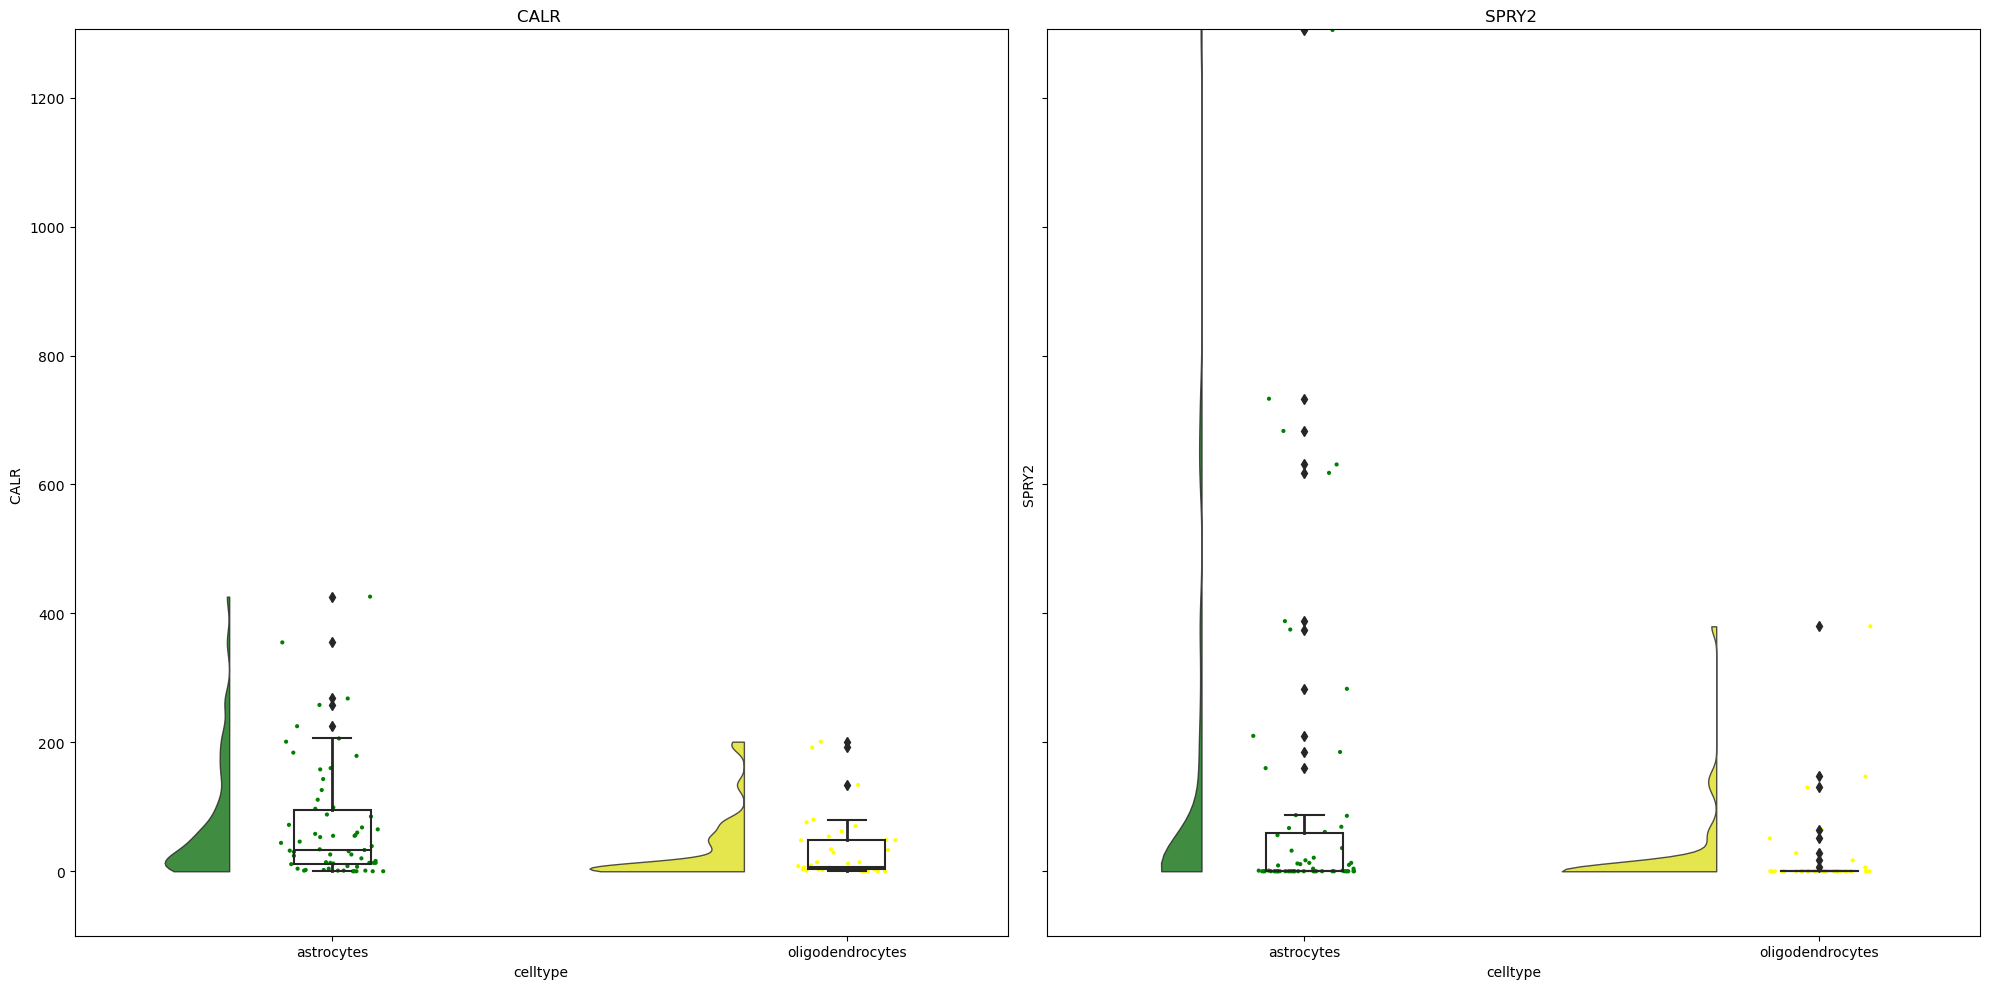

In [50]:
features = list(g1)

palette = {'astrocytes': 'green', 'oligodendrocytes': 'yellow'}
# Plot multiple raincloud plots for the 10 features in a single row
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    
    # Create the Raincloud Plot using ptitprince
    pt.RainCloud(x='celltype', y=feature, data=combined,
                 palette=palette, width_viol=0.6, alpha=0.8, ax=ax, orient='v')
    
    # Set title for each subplot
    ax.set_title(feature)
    
    ax.set_ylim(-100, combined[feature].max() + 1)

# Adjust layout and remove redundant frames
plt.tight_layout()
plt.show()


In [54]:
stat_res.results_df[stat_res.results_df.index.isin(g1)]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
CALR,39.944795,-1.030693,0.410392,-2.511484,0.012022,0.044188
SPRY2,48.325001,-2.508650,1.003076,-2.500957,0.012386,0.045255


### Plot of $\log_{10}pval$ from each of the individual method and the combined method
- Here all top 20 genes from each method gets low $\log_{10}pval$ contribution from Wilcoxon method

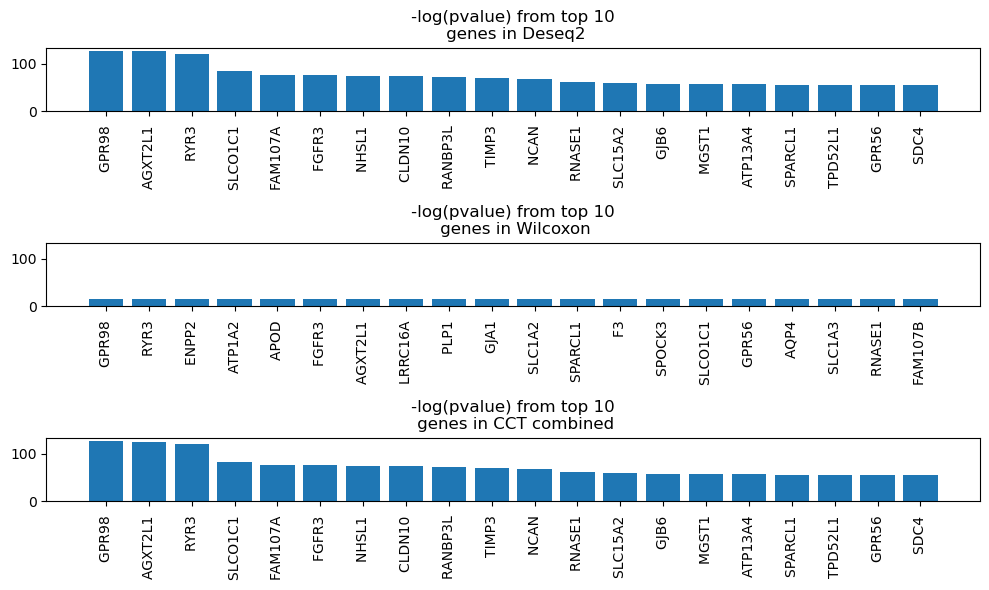

In [59]:
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharey=True)
n = 20

gr1 = list(frame.sort_values(by = 'pvalue')[:n].genes)
gr2 = list(frame.sort_values(by = 'pvalue_wc')[:n].genes)
gr3 = list(frame.sort_values(by = 'pvalue_cct')[:n].genes)

p1 = [ -np.log10(x) for x in list(frame.sort_values(by = 'pvalue')[:n].pvalue)]
p2 = [ -np.log10(x) for x in list(frame.sort_values(by = 'pvalue_wc')[:n].pvalue_wc)]
p3 = [ -np.log10(x) for x in list(frame.sort_values(by = 'pvalue_cct')[:n].pvalue_cct)]

axes[0].bar(gr1, p1)
axes[0].set_title('-log(pvalue) from top 10\n genes in Deseq2')
axes[0].tick_params(axis='x', rotation=90)

axes[1].bar(gr2, p2)
axes[1].set_title('-log(pvalue) from top 10\n genes in Wilcoxon')
axes[1].tick_params(axis='x', rotation=90)

axes[2].bar(gr3, p3)
axes[2].set_title('-log(pvalue) from top 10\n genes in CCT combined')
axes[2].tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()